<a href="https://colab.research.google.com/github/IT21238994/24-25J-169-iTranz/blob/RouteModel_IT21298394/Route_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setup and installation


In [4]:
# Install required libraries
!pip install lightgbm shap
!pip install --upgrade lightgbm

# Import libraries
import pandas as pd
import numpy as np
import lightgbm as lgb
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

# Set plot styles
sns.set(style='whitegrid', palette='muted', font_scale=1.2)


Data loading

In [6]:
# Load the dataset
df = pd.read_csv('bus_schedule_sept_nov_2024.csv')

# Display first few rows
df.head()


,Date,Day,Time,Route,Traffic_Level,Delay (min),Distance (km),Full Trip Time(min),Average Speed (kmph),Average Bus Stop Time(min),Fare (LKR),Seat_Availability (%),Historical_Peak_Delay (min)
0,24.10.2024,Thursday,2:35 PM,356,Low,2,9.2,21,32.5,2.3,66,48,0
1,27.10.2024,Sunday,6:00 PM,380,Low,0,10.9,28,31.4,2.5,77,45,0
2,20.09.2024,Friday,12:50 PM,356,Medium,8,9.2,21,32.5,2.3,66,17,8
3,14.10.2024,Monday,5:20 PM,380,Low,1,10.9,28,31.4,2.5,77,47,0
4,16.09.2024,Monday,6:40 PM,380,Low,0,10.9,28,31.4,2.5,77,53,0


Feature Engineering

In [7]:
# Encode Traffic_Level
traffic_mapping = {'Low': 0, 'Medium': 1, 'High': 2, 'Very High': 3}
df['Traffic_Level_Encoded'] = df['Traffic_Level'].map(traffic_mapping)

# Encode Day of the Week
day_encoder = LabelEncoder()
df['Day_Encoded'] = day_encoder.fit_transform(df['Day'])

# Extract Hour and Minute from Time
from datetime import datetime

def extract_time_features(time_str):
    time_obj = datetime.strptime(time_str, '%I:%M %p')
    return time_obj.hour, time_obj.minute

df[['Hour', 'Minute']] = df['Time'].apply(lambda x: pd.Series(extract_time_features(x)))

# Represent Time Cyclically
df['Hour_Sin'] = np.sin(2 * np.pi * df['Hour']/24)
df['Hour_Cos'] = np.cos(2 * np.pi * df['Hour']/24)
df['Minute_Sin'] = np.sin(2 * np.pi * df['Minute']/60)
df['Minute_Cos'] = np.cos(2 * np.pi * df['Minute']/60)

Handling special days

In [8]:
# Define special days
special_days = {
    '2024-11-11': 'Sale Day',
    '2024-11-29': 'Black Friday',
    '2024-11-30': 'Black Friday',
    '2024-09-15': 'Local Festival',
    '2024-10-10': 'Public Holiday',
    '2024-10-25': 'Market Day'
}

# Convert Date to datetime
df['Date_dt'] = pd.to_datetime(df['Date'], format='%d.%m.%Y')

# Create Special_Day binary feature
df['Special_Day'] = df['Date_dt'].dt.strftime('%Y-%m-%d').isin(special_days.keys()).astype(int)

# Create Event_Type encoded feature
event_mapping = {v: k for k, v in enumerate(set(special_days.values()), start=1)}
df['Event_Type'] = df['Date_dt'].dt.strftime('%Y-%m-%d').map(lambda x: event_mapping[special_days[x]] if x in special_days else 0)

# Interaction Feature: Traffic_Level * Event_Type
df['Traffic_Event_Interaction'] = df['Traffic_Level_Encoded'] * df['Event_Type']


User Preferences Integration

In [9]:
# Simulate User Preferences
# Assuming 1000 unique users
num_users = 1000
np.random.seed(42)
user_ids = np.random.choice(range(1, num_users+1), size=len(df))

df['User_ID'] = user_ids

# Generate synthetic user preferences
user_preferences = pd.DataFrame({
    'User_ID': range(1, num_users+1),
    'Fare_Sensitivity': np.random.choice(['Low', 'High'], size=num_users, p=[0.7, 0.3]),
    'Comfort_Preference': np.random.randint(1, 6, size=num_users)  # Scale 1-5
})

# Merge with main dataset
df = df.merge(user_preferences, on='User_ID', how='left')

# Encode User Preferences
fare_mapping = {'Low': 0, 'High': 1}
df['Fare_Sensitivity_Encoded'] = df['Fare_Sensitivity'].map(fare_mapping)


Real-Time Delay Simulation

In [10]:
# Simulate Real-Time Delay Updates
df['Real_Time_Delay'] = df['Delay (min)'] + np.random.randint(-2, 3, size=len(df))  # +/-2 minutes variability
df['Real_Time_Delay'] = df['Real_Time_Delay'].apply(lambda x: max(x, 0))  # Ensure non-negative delays


Composite Route Score and Target Variable

In [11]:
# Define composite score
weight_delay = -0.4  # Negative weight as lower delay is better
weight_fare = -0.3   # Negative weight as lower fare is better
weight_seat = 0.3    # Positive weight as higher seat availability is better

df['Route_Score'] = (weight_delay * df['Delay (min)'] +
                     weight_fare * df['Fare (LKR)'] +
                     weight_seat * df['Seat_Availability (%)'])

# Normalize Route_Score
df['Route_Score_Normalized'] = (df['Route_Score'] - df['Route_Score'].min()) / (df['Route_Score'].max() - df['Route_Score'].min())

# Define the best route as the one with the highest score per journey (Date, Time, User_ID)
df['Best_Route'] = df.groupby(['Date_dt', 'Time', 'User_ID'])['Route_Score_Normalized'].transform(lambda x: (x == x.max()).astype(int))


# **Model Training with LightGBM**

Preparing Features and Target

In [12]:
# Define feature columns
feature_cols = [
    'Traffic_Level_Encoded', 'Day_Encoded', 'Hour_Sin', 'Hour_Cos',
    'Minute_Sin', 'Minute_Cos', 'Special_Day', 'Event_Type',
    'Traffic_Event_Interaction', 'Delay (min)', 'Fare (LKR)',
    'Seat_Availability (%)', 'Distance (km)', 'Full Trip Time(min)',
    'Average Speed (kmph)', 'Average Bus Stop Time(min)',
    'Fare_Sensitivity_Encoded', 'Comfort_Preference', 'Real_Time_Delay'
]

X = df[feature_cols]
y = df['Best_Route']


Handling Class Imbalance

Best_Route
1    3926
Name: count, dtype: int64


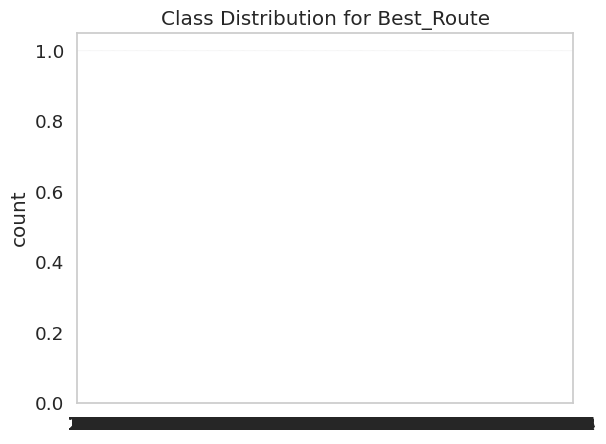

In [13]:
# Check class distribution
print(y.value_counts())

# Plot class distribution
sns.countplot(y)
plt.title('Class Distribution for Best_Route')
plt.show()


In [14]:
# Define LightGBM parameters with handling for class imbalance
params = {
    'objective': 'binary',
    'metric': ['binary_logloss', 'auc'],
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'is_unbalance': True,  # Handle class imbalance
    'verbose': -1
}


In [15]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Create LightGBM datasets
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Train the model using callbacks for early stopping
gbm = lgb.train(
    params,
    train_data,
    num_boost_round=1000,
    valid_sets=[valid_data],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),  # Early stopping callback
        lgb.log_evaluation(period=100)          # Log evaluation every 100 iterations
    ]
)


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 1.11022e-15	valid_0's auc: 1


# Model **Evaluation**

In [16]:
# Predict probabilities
y_pred_prob = gbm.predict(X_test, num_iteration=gbm.best_iteration)

# Convert probabilities to binary predictions
y_pred = [1 if prob >= 0.5 else 0 for prob in y_pred_prob]

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_prob)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print(f'AUC: {auc:.4f}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)


ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

# **Feature Importance and SHAP Analysis**

In [ ]:
# Plot feature importance
lgb.plot_importance(gbm, max_num_features=15, importance_type='split', figsize=(10,6))
plt.title('Feature Importance (Split)')
plt.show()

lgb.plot_importance(gbm, max_num_features=15, importance_type='gain', figsize=(10,6))
plt.title('Feature Importance (Gain)')
plt.show()


In [ ]:
#SHAP Analysis
# Initialize SHAP explainer
explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test, plot_type="bar")
